In [1]:
!pip install torchview
!pip install graphviz

import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn as nn
from torchvision import models as torch_model
import os
import math
import time
from matplotlib import pyplot as plt
import graphviz
from torchview import draw_graph
import numpy as np
import multiprocessing as mp
import seaborn as sns

In [2]:
dir_name = os.getcwd()
batch_size = 128
learning_rate = 0.01
num_epochs = 7
out_classes = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
crossentropy_loss = torch.nn.CrossEntropyLoss()

models_accuracies = []

In [3]:
def get_accuracy_and_loss(model, data_loader, device, crossentropy_loss):
    tp = 0
    n = 0
    loss = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
            loss += crossentropy_loss(outputs, labels)
    return tp / n, loss / n

def accuracy(outputs, labels):
  _, predicted = torch.max(outputs.data, 1)
  return torch.tensor(torch.sum(predicted == labels).item() / len(predicted))

In [4]:
def train(net, data_loader, epochs_num, loss_function, optimizer, device):
  start_time = time.time()
  for epoch in range(epochs_num):
    start_epoch_time = time.time()
    accuracies = []
    losses = []
    for i, (images, labels) in enumerate(data_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = loss_function(outputs, labels)
        acc = accuracy(outputs, labels)

        losses.append(loss)
        accuracies.append(acc)

        loss.backward()
        optimizer.step()
    finish_epoch_time = time.time()
    epoch_time = finish_epoch_time - start_epoch_time
    print('Epoch № {}: loss = {:.3f}, accuracy = {:.3f}, Time = {:.3f}'.format(epoch, torch.stack(losses).mean(), torch.stack(accuracies).mean(), epoch_time))
  res_time = time.time() - start_time
  print('Result training time {}'.format(res_time))

In [5]:
def test(net, test_data_loader, device, crossentropy_loss):
  accuracy_value, loss_value = get_accuracy_and_loss(net, test_data_loader, device, crossentropy_loss)
  print('Test accuracy = {:.3f}, test loss = {:.3f}'.format(accuracy_value, loss_value))
  models_accuracies.append(accuracy_value)

In [6]:
def updateFc(net, train_data_loader, test_data_loader, updated_layer):
  if hasattr(net, 'fc'):
        net.fc = updated_layer
  elif hasattr(net, 'classifier'):
        net.classifier = updated_layer

  net.to(device)
  optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
  train(net, train_data_loader, num_epochs, crossentropy_loss, optimizer, device)
  test(net, test_data_loader, device, crossentropy_loss)
  return net

def updateFcAndFreezeLayers(net, train_data_loader, test_data_loader, updated_layer):
  for param in net.parameters():
    param.requires_grad = False
  if hasattr(net, 'fc'):
        net.fc = updated_layer
        optimizer = torch.optim.Adam(net.fc.parameters(), lr = learning_rate)
  elif hasattr(net, 'classifier'):
        net.classifier = updated_layer
        optimizer = torch.optim.Adam(net.classifier.parameters(), lr = learning_rate)

  net.to(device)
  train(net, train_data_loader, num_epochs, crossentropy_loss, optimizer, device)
  test(net, test_data_loader, device, crossentropy_loss)
  return net

In [7]:
def loadData(transforms):
    train_dataset = torchvision.datasets.CIFAR10(
      root = dir_name, train = True, download = True,
      transform = transforms)

    test_dataset = torchvision.datasets.CIFAR10(
      root = dir_name, train = False, download = True,
      transform = transforms)

    train_data_loader = torch.utils.data.DataLoader(
      train_dataset, batch_size = batch_size, shuffle = True, num_workers = mp.cpu_count() - 2)

    test_data_loader = torch.utils.data.DataLoader(
      test_dataset, batch_size = batch_size, shuffle = False, num_workers = mp.cpu_count() - 2)

    return train_data_loader, test_data_loader

#ResNet18

# Experiment 1: full training

In [8]:
weights = torch_model.ResNet18_Weights.DEFAULT
net = torch_model.resnet18(weights)
transforms = weights.transforms()

train_data_loader, test_data_loader = loadData(transforms)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 67.2MB/s]


100%|██████████| 170498071/170498071 [00:06<00:00, 27226143.48it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified


In [9]:
net = updateFc(net, train_data_loader, test_data_loader, nn.Linear(net.fc.in_features, out_classes))

Epoch № 0: loss = 1.859, accuracy = 0.319, Time = 187.791
Epoch № 1: loss = 1.217, accuracy = 0.556, Time = 175.986
Epoch № 2: loss = 0.886, accuracy = 0.685, Time = 174.599
Epoch № 3: loss = 0.680, accuracy = 0.761, Time = 176.213
Epoch № 4: loss = 0.571, accuracy = 0.802, Time = 180.370
Epoch № 5: loss = 0.464, accuracy = 0.839, Time = 177.513
Epoch № 6: loss = 0.392, accuracy = 0.864, Time = 176.368
Result training time 1249.7912163734436
Test accuracy = 0.817, test loss = 0.004


In [10]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Experiment 2: partial training

In [11]:
weights = torch_model.ResNet18_Weights.DEFAULT
net = torch_model.resnet18(weights)
transforms = weights.transforms()

train_data_loader, test_data_loader = loadData(transforms)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
net = updateFcAndFreezeLayers(net, train_data_loader, test_data_loader, nn.Linear(net.fc.in_features, out_classes))

Epoch № 0: loss = 0.886, accuracy = 0.703, Time = 175.462
Epoch № 1: loss = 0.751, accuracy = 0.749, Time = 175.566
Epoch № 2: loss = 0.754, accuracy = 0.752, Time = 174.672
Epoch № 3: loss = 0.737, accuracy = 0.758, Time = 173.828
Epoch № 4: loss = 0.766, accuracy = 0.752, Time = 174.643
Epoch № 5: loss = 0.724, accuracy = 0.763, Time = 174.342
Epoch № 6: loss = 0.741, accuracy = 0.761, Time = 173.167
Result training time 1221.695728302002
Test accuracy = 0.754, test loss = 0.006


In [13]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# ResNet34

# Experiment **1**: full training

In [14]:
weights = torch_model.ResNet34_Weights.DEFAULT
net = torch_model.resnet34(weights)
transforms = weights.transforms()

train_data_loader, test_data_loader = loadData(transforms)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 102MB/s]


Files already downloaded and verified
Files already downloaded and verified


In [15]:
net = updateFc(net, train_data_loader, test_data_loader, nn.Linear(net.fc.in_features, out_classes))

Epoch № 0: loss = 1.901, accuracy = 0.297, Time = 240.410
Epoch № 1: loss = 1.270, accuracy = 0.536, Time = 241.709
Epoch № 2: loss = 0.922, accuracy = 0.673, Time = 241.433
Epoch № 3: loss = 0.684, accuracy = 0.762, Time = 241.315
Epoch № 4: loss = 0.531, accuracy = 0.817, Time = 241.197
Epoch № 5: loss = 0.430, accuracy = 0.852, Time = 240.806
Epoch № 6: loss = 0.346, accuracy = 0.880, Time = 240.342
Result training time 1688.8207566738129
Test accuracy = 0.825, test loss = 0.004


In [16]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Experiment 2: partial training

In [17]:
weights = torch_model.ResNet34_Weights.DEFAULT
net = torch_model.resnet34(weights)
transforms = weights.transforms()

train_data_loader, test_data_loader = loadData(transforms)

net = updateFcAndFreezeLayers(net, train_data_loader, test_data_loader, nn.Linear(net.fc.in_features, out_classes))

Files already downloaded and verified
Files already downloaded and verified
Epoch № 0: loss = 0.847, accuracy = 0.721, Time = 204.127
Epoch № 1: loss = 0.694, accuracy = 0.770, Time = 205.736
Epoch № 2: loss = 0.689, accuracy = 0.776, Time = 205.398
Epoch № 3: loss = 0.700, accuracy = 0.774, Time = 205.581
Epoch № 4: loss = 0.698, accuracy = 0.776, Time = 203.863
Epoch № 5: loss = 0.699, accuracy = 0.779, Time = 203.488
Epoch № 6: loss = 0.681, accuracy = 0.781, Time = 202.845
Result training time 1431.0498859882355
Test accuracy = 0.767, test loss = 0.006


In [18]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# MobileNet_V3_large

# Experiment 1: full training

In [19]:
weights = torch_model.MobileNet_V3_Large_Weights.DEFAULT
net = torch_model.mobilenet_v3_large(weights)
transforms = weights.transforms()

train_data_loader, test_data_loader = loadData(transforms)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 96.9MB/s]


Files already downloaded and verified
Files already downloaded and verified


In [20]:
new_classifier = nn.Sequential(
               nn.Linear(960, 1280),
                nn.Hardswish(),
                nn.Dropout(0.2),
                nn.Linear(1280, out_classes))

net = updateFc(net, train_data_loader, test_data_loader, new_classifier)

Epoch № 0: loss = 1.128, accuracy = 0.615, Time = 173.329
Epoch № 1: loss = 0.667, accuracy = 0.775, Time = 173.073
Epoch № 2: loss = 0.547, accuracy = 0.820, Time = 173.801
Epoch № 3: loss = 0.495, accuracy = 0.838, Time = 172.898
Epoch № 4: loss = 0.454, accuracy = 0.851, Time = 172.440
Epoch № 5: loss = 0.414, accuracy = 0.865, Time = 173.014
Epoch № 6: loss = 0.380, accuracy = 0.875, Time = 174.236
Result training time 1213.612648487091
Test accuracy = 0.840, test loss = 0.004


In [21]:
net

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

# Experiment 2: partial training

In [22]:
weights = torch_model.MobileNet_V3_Large_Weights.DEFAULT
net = torch_model.mobilenet_v3_large(weights)
transforms = weights.transforms()
train_data_loader, test_data_loader = loadData(transforms)

net = updateFcAndFreezeLayers(net, train_data_loader, test_data_loader, new_classifier)

Files already downloaded and verified
Files already downloaded and verified
Epoch № 0: loss = 4.933, accuracy = 0.642, Time = 165.810
Epoch № 1: loss = 0.739, accuracy = 0.749, Time = 166.268
Epoch № 2: loss = 0.655, accuracy = 0.773, Time = 166.094
Epoch № 3: loss = 0.606, accuracy = 0.791, Time = 165.762
Epoch № 4: loss = 0.582, accuracy = 0.798, Time = 165.429
Epoch № 5: loss = 0.566, accuracy = 0.804, Time = 165.276
Epoch № 6: loss = 0.562, accuracy = 0.805, Time = 165.707
Result training time 1160.3582365512848
Test accuracy = 0.727, test loss = 0.007


In [23]:
net

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

# RegNet-Y-800MF

# Experiment 1: full training

In [24]:
weights = torch_model.RegNet_Y_800MF_Weights.DEFAULT
net = torch_model.regnet_y_800mf(weights)
transforms = weights.transforms()

train_data_loader, test_data_loader = loadData(transforms)

Downloading: "https://download.pytorch.org/models/regnet_y_800mf-58fc7688.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_800mf-58fc7688.pth
100%|██████████| 24.8M/24.8M [00:00<00:00, 159MB/s]


Files already downloaded and verified
Files already downloaded and verified


In [25]:
net = updateFc(net, train_data_loader, test_data_loader, nn.Linear(net.fc.in_features, out_classes))

Epoch № 0: loss = 1.237, accuracy = 0.553, Time = 440.203
Epoch № 1: loss = 0.759, accuracy = 0.733, Time = 441.311
Epoch № 2: loss = 0.556, accuracy = 0.807, Time = 441.236
Epoch № 3: loss = 0.445, accuracy = 0.846, Time = 441.172
Epoch № 4: loss = 0.364, accuracy = 0.875, Time = 441.413
Epoch № 5: loss = 0.306, accuracy = 0.894, Time = 441.260
Epoch № 6: loss = 0.254, accuracy = 0.911, Time = 441.467
Result training time 3090.2892401218414
Test accuracy = 0.864, test loss = 0.003


In [26]:
net

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            

# Experiment 2: partial training

In [27]:
weights = torch_model.RegNet_Y_800MF_Weights.DEFAULT
net = torch_model.regnet_y_800mf(weights)
transforms = weights.transforms()

train_data_loader, test_data_loader = loadData(transforms)

net = updateFcAndFreezeLayers(net, train_data_loader, test_data_loader, nn.Linear(net.fc.in_features, out_classes))

Files already downloaded and verified
Files already downloaded and verified
Epoch № 0: loss = 0.801, accuracy = 0.732, Time = 332.830
Epoch № 1: loss = 0.678, accuracy = 0.776, Time = 332.185
Epoch № 2: loss = 0.662, accuracy = 0.781, Time = 331.696
Epoch № 3: loss = 0.656, accuracy = 0.786, Time = 333.141
Epoch № 4: loss = 0.667, accuracy = 0.784, Time = 334.167
Epoch № 5: loss = 0.660, accuracy = 0.786, Time = 333.737
Epoch № 6: loss = 0.654, accuracy = 0.789, Time = 332.504
Result training time 2330.2765312194824
Test accuracy = 0.770, test loss = 0.006


In [28]:
net

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=4, bias=False)
            

# Common results

In [29]:
model_experiment_names = ("ResNet18_full", "ResNet18_partial",
                          "ResNet34_full", "ResNet34_partial",
                          "MobileNet_V3_large_full", "MobileNet_V3_large_partial",
                          "RegNet-Y-800MF_full", "RegNet-Y-800MF_partial")

results = {}

for i in range(len(models_accuracies)):
  results[model_experiment_names[i]] = round(models_accuracies[i].item(), 3)

#Practical work 1 result
results["My ResNet50"] = 0.786

results

{'ResNet18_full': 0.817,
 'ResNet18_partial': 0.754,
 'ResNet34_full': 0.825,
 'ResNet34_partial': 0.767,
 'MobileNet_V3_large_full': 0.84,
 'MobileNet_V3_large_partial': 0.727,
 'RegNet-Y-800MF_full': 0.864,
 'RegNet-Y-800MF_partial': 0.77,
 'My ResNet50': 0.786}

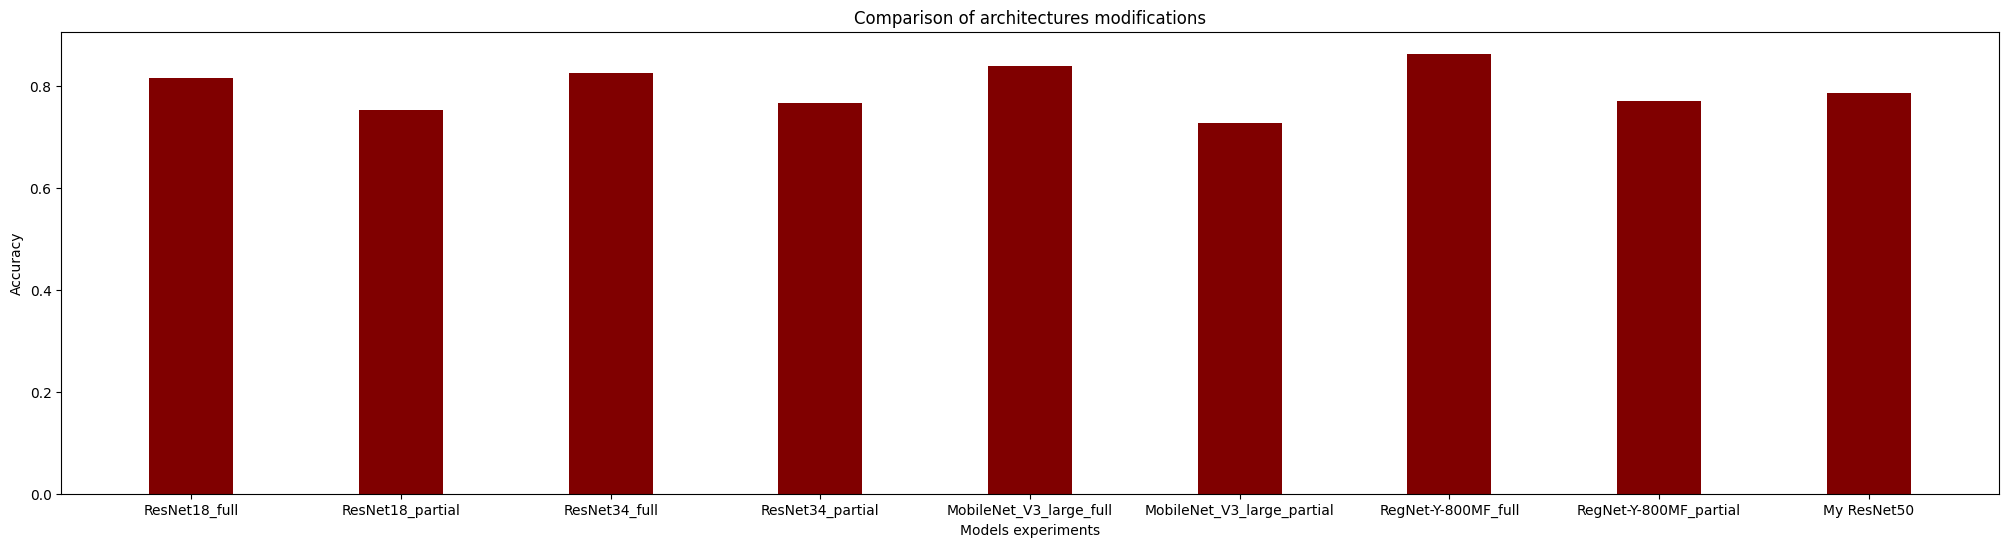

In [30]:
fig = plt.figure(figsize = (25, 6))

plt.bar(results.keys(), results.values(), color ='maroon',
        width = 0.4)

plt.xlabel("Models experiments")
plt.ylabel("Accuracy")
plt.title("Comparison of architectures modifications")
plt.show()